# DQN-EMS

In [1]:
# -*- coding: utf-8 -*-
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用cpu
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow.compat.v1 as tf
import numpy as np
from EREV_model import EREV_model
import scipy.io as scio
import matplotlib.pyplot as plt
from Priority_Replay import Memory, SumTree

## 超参数

In [2]:
MAX_EPISODES = 1               # 1500 运行次数
memory_capacity = 10000         # 记忆容量
batch_size = 64                 # 一次训练所抓取的数据样本数量
learning_rate = 0.001           # 学习率：旧的Q值将从新的Q值哪里学到的新Q占自身的多少比重。
                                # 值为0代理不会学到任何东西（旧信息是重要的），值为1新发现的信息是唯一重要的信息。
reward_decay = 0.9              # 奖励递减未来奖励的重要性。
                                # 值为0意味着只考虑短期奖励，其中1的值更重视长期奖励。
e_greedy = 1                    # 贪心 利用概率ε来选择随机动作
e_greedy_increment = 0.00001    # 贪心递减
replace_target_iter = 300       # 每300步更新target参数
np.random.seed(1)               # 如果使用相同的seed()值，则每次生成的随即数都相同
tf.set_random_seed(1)
tf.reset_default_graph()   # Python的控制台会保存上次运行结束的变量
output_graph = True

## DQN算法

In [3]:
class DeepQNetwork():
    def __init__(self, a_dim, s_dim):
        self.a_dim = a_dim                                   # 动作
        self.s_dim = s_dim                                   # 状态
        self.lr = learning_rate                              # 学习率
        self.gamma = reward_decay                            # 奖励递减
        self.epsilon_max = e_greedy                          # 贪心
        self.epsilon_increment = e_greedy_increment          # 贪心递减
        self.replace_target_iter = replace_target_iter       # 更新target
        self.memory_size = memory_capacity                   # 记忆库容量
        self.batch_size = batch_size
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max # 更新epsilon贪心
        self.learn_step_counter = 0                          # 记录学习次数
        self.memory = Memory(capacity = memory_capacity)     # 存储记忆
        self.ISWeights = tf.placeholder(tf.float32, [None, 1], 'ISWeights')
        self._build_net()
        self.t_params = tf.get_collection('target_net_params') # 列出目标网络的所有参数
                                                               # f.get_collection:从一个集合中取出变量
        self.e_params = tf.get_collection('eval_net_params')   # 列出评价网络的所有参数
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(self.t_params, self.e_params)]# 网络参数替换
                                                               # tf.assign:将t的值变为e
        self.sess = tf.Session()                               # Session 是 Tensorflow 为了控制,和输出文件的执行的语句
        self.sess.run(tf.global_variables_initializer())       # 运行 session.run() 可以获得你要得知的运算结果
        self.t_params = self.sess.run(self.t_params)           # 或者是你所要运算的部分.
        self.e_params = self.sess.run(self.e_params)
        self.cost_history = []                                 # 存储消耗

    def _build_net(self):
        ############################## 评价网络
        # eval_net 四层，输入：s_dim(状态空间)；输出：a_dim(动作空间)
        # tf.placeholder:在神经网络构建graph的时候在模型中的占位，此时并没有把要输入的数据传入模型，它只会分配必要的内存。
        # 等建立session，在会话中，运行模型的时候通过feed_dict()函数向占位符喂入数据。
        self.s = tf.placeholder(tf.float32, [None, self.s_dim], name = 's')
        self.q_target = tf.placeholder(tf.float32, [None, self.a_dim], name = 'q_target')
        # tf.variable_scope:在模型中开辟各自的空间，而其中的变量均在这个空间内进行管理
        # with:上下文管理，需要事先做一些设置，事后做一些清理
        with tf.variable_scope('eval_net'):
            c_names, n_unit, w_initializer, b_initializer = \
            ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 200,\
            tf.random_normal_initializer(0, 0.3), tf.constant_initializer(0.1)
            # 返回一个生成具有正态分布的张量的初始化器
            # tf.get_variable(名称name、变量规格shape、变量初始化方式initializer、所属集合collections。)
            with tf.variable_scope('layer1'):
                w1 = tf.get_variable('w1', [self.s_dim, n_unit], initializer = w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_unit], initializer = b_initializer, collections = c_names)
                layer1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)
                
            with tf.variable_scope('layer2'):
                w2 = tf.get_variable('w2', [200, 100], initializer = w_initializer, collections = c_names)
                b2 = tf.get_variable('b2', [1, 100], initializer = b_initializer, collections = c_names)
                layer2 = tf.nn.relu(tf.matmul(layer1, w2) + b2)    
                
            with tf.variable_scope('layer3'):
                w3 = tf.get_variable('w3', [100, 50], initializer = w_initializer, collections = c_names)
                b3 = tf.get_variable('b3', [1, 50], initializer = b_initializer, collections = c_names)
                layer3 = tf.nn.relu(tf.matmul(layer2, w3) + b3)  
                
            with tf.variable_scope('layer4'):
                w4 = tf.get_variable('w4', [50, self.a_dim], initializer = w_initializer, collections = c_names)
                b4 = tf.get_variable('b4', [1, self.a_dim], initializer = b_initializer, collections = c_names)
                self.q_eval = tf.matmul(layer3, w4) + b4
        # tf.squared_difference:矩阵x，y按元素求（x-y）²
        # tf.reduce_mean：计算平均值
        with tf.variable_scope('loss'):
            # 从重播缓冲区中抽取随机批次的转换，并用以下公式计算损失
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval)) * self.ISWeights
        # 梯度下降算法
        # 针对实际网络参数，执行梯度下降，以使损失最小化
        with tf.variable_scope('train_op'):
            self.train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)
        
        ##############################  目标网络
        self.s_ = tf.placeholder(tf.float32, [None, self.s_dim], name = 's_')
        # target_net 四层，输入：s_dim(状态空间)；输出：a_dim(动作空间)
        with tf.variable_scope('target_net'):
            c_names, n_unit, w_initializer, b_initializer = \
            ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 200,\
            tf.random_normal_initializer(0, 0.3), tf.constant_initializer(0.1)
            
            with tf.variable_scope('layer1'):
                w1 = tf.get_variable('w1', [self.s_dim, n_unit], initializer = w_initializer, collections = c_names)
                b1 = tf.get_variable('b1', [1, n_unit], initializer = b_initializer, collections = c_names)
                layer1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)
                
            with tf.variable_scope('layer2'):
                w2 = tf.get_variable('w2', [200, 100], initializer = w_initializer, collections = c_names)
                b2 = tf.get_variable('b2', [1, 100], initializer = b_initializer, collections = c_names)
                layer2 = tf.nn.relu(tf.matmul(layer1, w2) + b2)
                
            with tf.variable_scope('layer3'):
                w3 = tf.get_variable('w3', [100, 50], initializer = w_initializer, collections = c_names)
                b3 = tf.get_variable('b3', [1, 50], initializer = b_initializer, collections = c_names)
                layer3 = tf.nn.relu(tf.matmul(layer2, w3) + b3)
            
            with tf.variable_scope('layer4'):
                w4 = tf.get_variable('w4', [50, self.a_dim], initializer = w_initializer, collections = c_names)
                b4 = tf.get_variable('b4', [1, self.a_dim], initializer = b_initializer, collections = c_names)
                self.q_next = tf.matmul(layer3, w4) + b4  
       
        with tf.Session() as sess:#运算结束后session自动关闭
            sess.run(tf.global_variables_initializer())#执行运算
            self.saver = tf.train.Saver(max_to_keep = MAX_EPISODES)
            #保存模型，参数max_to_keep ，用来设置保存模型的个数，默认为5
                        
    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        # 沿着水平方向将数组堆叠起来
        transition = np.hstack((s, a, r, s_))

        self.memory.store(transition)            
        self.memory_counter += 1
            
    def choose_action(self, observation):
        observation = observation[np.newaxis, :]
        # np.newaxis:选取部分的数据增加一个维度
        if np.random.uniform() < self.epsilon:
            action_value = self.sess.run(self.q_eval, feed_dict = {self.s: observation})
            action = np.argmax(action_value)            
        else:
            action = np.random.randint(0, self.a_dim)
                
        return action
        
    def learn(self):
        # 更新神经网络参数
        # 每隔k步之后，拷贝实际网络权重到目标网络权重中
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            
        tree_index, batch_memory, ISWeights = self.memory.sample(batch_size)
            
        q_eval, q_next = self.sess.run([self.q_eval, self.q_next], feed_dict = {self.s: batch_memory[:, :self.s_dim], self.s_: batch_memory[:, -self.s_dim:]})
        q_target = q_eval.copy()
        
        batch_index = np.arange(self.batch_size, dtype = np.int32)
        eval_act_index = batch_memory[:, self.s_dim].astype(int)
        reward = batch_memory[:, self.s_dim + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis = 1)

        abs_td_error = np.abs(q_target[batch_index, eval_act_index] - q_eval[batch_index, eval_act_index]) * np.array(ISWeights).flatten()        
        self.memory.batch_update(tree_index, abs_td_error)
            
        _, self.cost = self.sess.run([self.train_op, self.loss], feed_dict = {self.s: batch_memory[:, :self.s_dim], self.q_target: q_target, self.ISWeights: ISWeights})
        self.cost_history.append(self.cost)
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        exploration = self.epsilon        
        self.learn_step_counter += 1

        return exploration

    def savemodel(self):
        self.saver.save(self.sess, 'save\save_net.ckpt', global_step = step_episode)

## 运行参数

In [4]:
s_dim = 3                                                    # 状态
a_dim = 14                                                   # 动作
DQN = DeepQNetwork(a_dim, s_dim)                             # 输入动作与状态参数
data_path = 'Data_Standard Driving Cycles/Standard_NEDC.mat' # 驾驶循环
data = scio.loadmat(data_path)                               # 驾驶循环数据
car_spd_one = data['speed_vector']                           # 每秒速度  m/s
total_milage = np.sum(car_spd_one) / 1000                    # 总行驶里程
exploration = 1
total_step = 0                                               # 累计步数
step_episode = 0                                             # 步数
mean_reward = 0                                              # 平均奖励
mean_reward_all = 0                                          # 总平均奖励
cost_Engine_list = []                                        # 燃油消耗
cost_all_list = []                                           # 奖励和等效燃油总消耗
cost_Engine_100Km_list = []                                  # 每百公里总消耗
mean_reward_list = []                                        # 平均奖励
list_even = []
list_odd = []
mean_discrepancy_list = []
SOC_final_list = []                                          # 最终SOC
EREV = EREV_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## 循环

In [9]:
for i in range(MAX_EPISODES):
    ep_reward = 0         # 每步奖励
    ep_reward_all = 0     # 循环奖励和
    a = 0                 # 动作
    step_episode += 1     # 每步加一
    Reward_list = []      # 奖励
    Reward_list_all = []  # 循环奖励
    # 发动机
    Eng_spd_list = []     # 发动机转速
    Eng_trq_list = []     # 发动机转矩
    Eng_pwr_list = []     # 发动机功率
    Eng_eta_list = []     # 发动机效率
    Eng_pwr_opt_list = [] # 发动机工作点
    # 发电机
    Gen_spd_list = []     # 发电机转速
    Gen_trq_list = []     # 发电机转矩
    Gen_pwr_list = []     # 发电机功率
    Gen_eta_list = []     # 发电机效率
    # 驱动电机
    Mot_spd_list = []     # 驱动电机转速
    Mot_trq_list = []     # 驱动电机转矩
    Mot_pwr_list = []     # 驱动电机功率
    Mot_eta_list = []     # 驱动电机效率
    # 电池
    Batt_pwr_list = []    # 电池输出功率
    inf_batt_list = []    # 超出电流限制
    inf_batt_one_list = []# 超出功率限制
    # 整车
    SOC = 0.65            # 初始SOC
    SOC_origin = SOC      # 初始SOC
    SOC_data = []         # soc
    P_req_list = []       # 轮胎驱动需求功率
    P_out_list = []       # 电池+增程器=输出功率
    T = 0                 # 驱动、制动转矩
    T_new = 0             # 驱动、制动转矩更新状态
    T_list = []           # 驱动、制动转矩列表
    car_spd = car_spd_one[:, 0]   # 车速
    car_a = car_spd_one[:, 0] - 0 # 加速度
    car_a_list = []                         # 加速度列表
    # 车辆初始状态
    s = np.zeros(s_dim)     # 车辆状态
    s[0] = car_spd / 33.4   # 车速 / 最大车速
    s[1] = T / 2000         # 将加速度改为驱动和制动转矩   (car_a - (-1.5)) / (1.5- (-1.5))
    s[2] = SOC              # SOC
    # 驾驶工况循环   1-1219
    for j in range(car_spd_one.shape[1] - 1):
        # 动作对应的发动机功率
        action = DQN.choose_action(s)
        if action == 0:
            a += 0
        if action == 1:
            a += (  1 / 105)
        if action == 2:
            a += ( -1 / 105)
        if action == 3:
            a += (  2 / 105)
        if action == 4:
            a += ( -2 / 105)
        if action == 5:
            a += (  4 / 105)
        if action == 6:
            a += ( -4 / 105)
        if action == 7:
            a += (  6 / 105)
        if action == 8:
            a += ( -6 / 105)
        if action == 9:
            a += (  8 / 105)
        if action == 10:
            a += ( -8 / 105)
        if action == 11:
            a += ( 10 / 105)
        if action == 12:
            a += (-10 / 105)
        if action == 13:
            a = 0
        Eng_pwr_opt = a * 105000
        # 运行增程式电动汽车模型   这里是car_a，不能改为T
        out, cost, I = EREV.run(car_spd, car_a, Eng_pwr_opt, SOC)
        P_req_list.append(float(out['P_req']))              # 轮胎驱动需求功率
        P_out_list.append(float(out['P_out']))              # 电池+增程器=输出功率
        # 发动机
        Eng_spd_list.append(float(out['Eng_spd']))          # 发动机转速
        Eng_trq_list.append(float(out['Eng_trq']))          # 发动机转矩
        Eng_pwr_list.append(float(out['Eng_pwr']))          # 发动机功率
        Eng_pwr_opt_list.append(float(out['Eng_pwr_opt']))  # 发动机工作点
        Eng_eta_list.append(float(out['Mot_eta']))          # 发动机效率
        # 发电机
        Gen_spd_list.append(float(out['Gen_spd']))          # 发电机转速
        Gen_trq_list.append(float(out['Gen_trq']))          # 发电机转矩
        Gen_pwr_list.append(float(out['Gen_pwr']))          # 发电机功率
        Gen_eta_list.append(float(out['Gen_eta']))          # 发电机效率
        # 驱动电机
        Mot_spd_list.append(float(out['Mot_spd']))          # 驱动电机转速
        Mot_trq_list.append(float(out['Mot_trq']))          # 驱动电机转矩
        Mot_pwr_list.append(float(out['Mot_pwr']))          # 驱动电机功率
        Mot_eta_list.append(float(out['Mot_eta']))          # 驱动电机效率
        # 电池
        Batt_pwr_list.append(float(out['Batt_pwr']))        # 电池功率
        inf_batt_list.append(int(out['inf_batt']))          # 超出电流限制
        inf_batt_one_list.append(int(out['inf_batt_one']))  # 超出功率限制
        SOC_new = float(out['SOC'])                         # SOC变化
        SOC_data.append(SOC_new)                            # SOC列表
        # 驱动、制动转矩
        T_new = float(out['T'])                             # 驱动和制动转矩
        T_list.append(float(out['T']))                      # 转矩列表
        # 增程器消耗燃油  g
        cost = float(cost)
        # SOC (< 0.45 and >0.85) 燃油奖励 = cost(燃油)
        r = - cost              # 燃油奖励     <0
        ep_reward += r          # 燃油奖励和   <0
        Reward_list.append(r)   # 燃油奖励列表 <0
        # SOC (0.45～0.85)       奖励 = -(α|ΔSOC|^2 + βfuel)
        if SOC_new < 0.4 or SOC_new > 0.8:
            r = - ((350 * ((0.6 - SOC_new) ** 2)) + cost)
        # 下一步车辆状态
        car_spd = car_spd_one[:, j + 1]                      # 下一步车速
        car_a = car_spd_one[:, j + 1] - car_spd_one[:, j]    # 下一步加速度
        car_a_list.append(car_a)                   # 加速度列表
        s_ = np.zeros(s_dim)
        s_[0] = car_spd / 33.4
        s_[1] = T_new / 2000  # 加速度改为转矩 (car_a - (-1.5)) / (1.5- (-1.5))
        s_[2] = SOC_new
        DQN.store_transition(s, action, r, s_)      # 经验池
        if total_step > 10000 and (total_step % 5 == 0):
            exploration = DQN.learn()
        # 状态交换
        s = s_
        ep_reward_all += r           # 奖励和 -(α|ΔSOC|^2 + βfuel)  <0
        Reward_list_all.append(r)    # 循环奖励
        total_step += 1              # 步数加一
        SOC = SOC_new                # SOC更新
        T = T_new                    # 转矩更新
        # 完成每次循环工况输出
        if j == (car_spd_one.shape[1] - 2):  # j = 1218
            SOC_final_list.append(SOC)
            mean_reward = - ep_reward_all / car_spd_one.shape[1]  # 平均每秒奖励
            mean_reward_list.append(mean_reward)                  # 平均每秒奖励
            # 燃油消耗  L
            cost_Engine = - (ep_reward / 0.725 / 1000)   # 增程器燃油总消耗   L cost_Engine = - (cost / 0.725 / 1000)
            cost_all = - (ep_reward_all / 0.725 / 1000)  # 奖励和等效燃油消耗 L (-(α|ΔSOC|^2 + βfuel)) / 0.725 / 1000)
            # 燃油总消耗(cost_Engine) = 每次循环消耗的电量转变为燃油 + 增程器燃油总消耗
            cost_Engine += (SOC < SOC_origin) * (SOC_origin - SOC) * (350 * 75) * 3600 / 43070 / 0.725 / 1000
            cost_Engine_list.append(cost_Engine)
            # 百公里燃油消耗(cost_Engine_100Km_list) = 燃油总消耗(cost_Engine) / 总行驶里程(total_milage)
            cost_Engine_100Km_list.append(cost_Engine * (100 / total_milage))
            # 奖励和等效燃油消耗(cost_all) =  (-(α|ΔSOC|^2 + βfuel)) / 0.725 / 1000) + 每次循环消耗的电量转变为燃油
            cost_all += (SOC < SOC_origin) * (SOC_origin - SOC) * (350 * 75) * 3600 / 43070 / 0.725 / 1000
            cost_all_list.append(cost_all)

            print('循环次数:',i, '燃油消耗: %.3f g' % -ep_reward,'燃油消耗: %.3f L' % cost_Engine, '百公里燃油消耗: %.3f L/100km' % (cost_Engine * (100 / total_milage)), '最终SOC: %.3f' % SOC_new, 'Explore: %.3f' % exploration,)
            Reward_final = []
            Reward_final.append(ep_reward)
    # 平均每秒奖励和
    mean_reward_all += mean_reward   
    if (step_episode % 10) == 0 and step_episode >= 10:
        if (step_episode / 10) % 2 == 0:
            list_even.append(mean_reward_all)
        else:
            list_odd.append(mean_reward_all)
        mean_reward_all = 0 
    # 保存模型
    DQN.savemodel()
    

循环次数: 0 燃油消耗: 347.826 g 燃油消耗: 0.834 L 百公里燃油消耗: 7.631 L/100km 最终SOC: 0.533 Explore: 1.000
Instructions for updating:
Use standard file APIs to delete files with this prefix.


## 结果处理

In [6]:
mean_discrepancy_list = list(map(lambda x, y: y - x, list_even, list_odd))

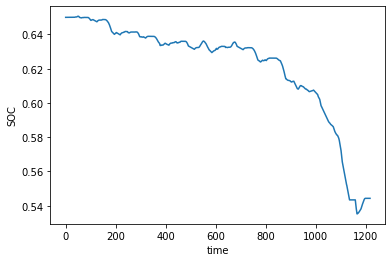

In [7]:
## SOC
x = np.arange(0, len(SOC_data), 1)
y = SOC_data
plt.plot(x, y)
plt.xlabel('time')
plt.ylabel('SOC')
plt.show()

In [12]:
max(car_a_list)

array([1.04166667])